# Imports

In [ ]:
import os
import math
import wave
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
# from keras.utils import np_utils
from tensorflow.keras.layers import Embedding,GRU,Dense,MaxPooling1D,Dropout
from tensorflow.keras.layers import LeakyReLU,ReLU,Flatten,concatenate,Bidirectional,TimeDistributed
from tensorflow.keras.layers import add,Conv1D,SeparableConv1D, GlobalMaxPooling2D,GlobalMaxPooling1D
from tensorflow.keras.layers import Conv2D,Input,Activation,BatchNormalization,MaxPooling2D
from tensorflow.keras.models import Sequential
# from keras.layers.merge import concatenate
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.applications.densenet import DenseNet201
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [ ]:
if not os.path.exists('/content/data/'):
    api_token = {"username":"sanikommupranavreddy","key":"b48566494bd446aefb3d0bcdcd54bd91"}
    with open('/content/kaggle.json', 'w') as file:
        json.dump(api_token, file)
    os.environ["KAGGLE_CONFIG_DIR"] = "/content/"
    os.system('kaggle datasets download -d vbookshelf/respiratory-sound-database')
    os.makedirs('/content/data/', exist_ok=True)
    os.system('mv /content/respiratory-sound-database.zip /content/data/respiratory-sound-database.zip')
    os.system('unzip -q /content/data/respiratory-sound-database.zip -d /content/data/')
    os.remove('/content/data/respiratory-sound-database.zip')

# Data Preprocessing

In [ ]:
os.listdir('/content/data/respiratory_sound_database/Respiratory_Sound_Database/')
df_no_diagnosis = pd.read_csv('/content/data/demographic_info.txt', names =
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')

diagnosis = pd.read_csv('/content/data/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [ ]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [ ]:
root = '/content/data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'

filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

## Read Respiratory Cycle Data

In [ ]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [ ]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

my_index = pd.Series(list(rec_annotations_dict.keys()))

## Get Respiratory Cycle Wheezes and Crackles

In [ ]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f[:3])

In [ ]:
file_label_df = pd.DataFrame(data = {'filename':filename_list, 'no label':no_label_list, 'crackles only':crack_list, 'wheezes only':wheeze_list, 'crackles and wheezees':both_sym_list})

In [ ]:
lables = file_label_df
lables.sort_values(by=['filename'])
sum = lables.groupby('filename').sum()

In [ ]:
conditions = [
    (sum['crackles only'] == 0) & (sum['wheezes only'] == 0) & (sum['crackles and wheezees'] == 0),
    (sum['crackles only'] == sum.max(axis=1)),
    (sum['wheezes only'] == sum.max(axis=1)),
    (sum['crackles and wheezees'] == sum.max(axis=1)),
    (sum['no label'] == sum.max(axis=1)) & (sum['crackles only'] > sum['wheezes only']) & (sum['crackles only'] > sum['crackles and wheezees']),
    (sum['no label'] == sum.max(axis=1)) & (sum['wheezes only'] >= sum['crackles only']) & (sum['wheezes only'] > sum['crackles and wheezees']),
    (sum['no label'] == sum.max(axis=1)) & (sum['crackles and wheezees'] >= sum['crackles only']) & (sum['crackles and wheezees'] >= sum['wheezes only']),
]

values = ['Healthy' , 'Crackles' , 'Wheezes','Wheezes & Crackles', 'Crackles' , 'Wheezes','Wheezes & Crackles']
sum = lables.groupby('filename').sum()
sum['diagnosis'] = np.select(conditions, values)
sum

,no label,crackles only,wheezes only,crackles and wheezees,diagnosis
filename,,,,,
101,23,0,0,0,Healthy
102,13,0,0,0,Healthy
103,2,0,4,0,Wheezes
104,44,1,10,0,Wheezes
105,8,0,0,0,Healthy
...,...,...,...,...,...
222,24,13,8,0,Crackles
223,29,19,13,0,Crackles
224,14,0,0,0,Healthy


Crackles              50
Wheezes               36
Healthy               34
Wheezes & Crackles     6
Name: diagnosis, dtype: int64

Crackles              39.682540
Wheezes               28.571429
Healthy               26.984127
Wheezes & Crackles     4.761905
Name: diagnosis, dtype: float64


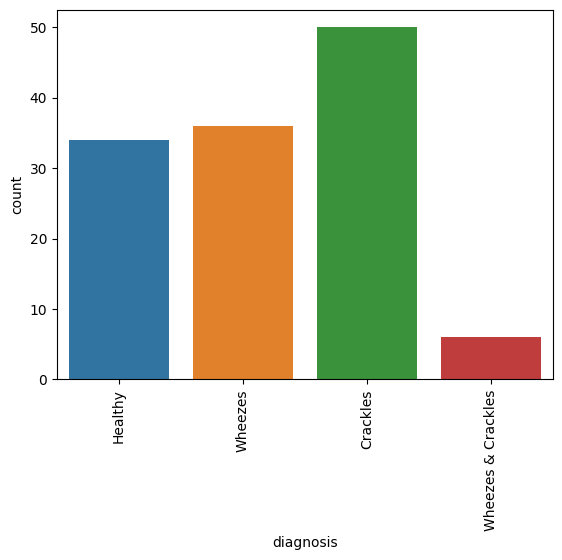

In [ ]:
print (sum.diagnosis.value_counts())
print ('')
print (sum.diagnosis.value_counts(normalize=True) *100)

import matplotlib.pyplot as plt

# Assuming sum is a DataFrame and diagnosis is a column in it
sns.countplot(data=sum, x='diagnosis')
plt.xticks(rotation=90)
plt.show()

## Save Diagnosis Data

In [ ]:
sum.diagnosis.to_csv('wheezes_crackles_diagnosis.csv')

## Data Augmentation

In [ ]:
audio_data = '/content/data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'

In [ ]:
diagnosis_df = pd.read_csv('/content/wheezes_crackles_diagnosis.csv', names=['patient_id', 'disease'],header=0)
diagnosis_df.head(4)

,patient_id,disease
0,101,Healthy
1,102,Healthy
2,103,Wheezes
3,104,Wheezes


In [ ]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [ ]:
def mfcc_feature_exteraction_wheezes(dir_):
    X_=[]
    y_=[]
    crackles=[]
    crackles_count=0
    data = diagnosis_df
    features = 52
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav':

            p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]

            if (p=='Crackles'):
                if (soundDir[:7] in crackles) and crackles_count<2:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    crackles.append(soundDir[:7])
                    crackles_count+=1
                    X_.append(mfccs)
                    y_.append('Not Wheezes')

                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                    X_.append(mfccs_stretch)
                    y_.append('Not Wheezes')

                if (soundDir[:7] not in crackles):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    crackles.append(soundDir[:7])
                    crackles_count=0
                    X_.append(mfccs)
                    y_.append('Not Wheezes')

                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                    X_.append(mfccs_stretch)
                    y_.append('Not Wheezes')

            if (p == 'Wheezes'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append('Wheezes')

                data_stretch = stretch(data_x,1.2)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch)
                y_.append('Wheezes')

                data_stretch_2 = stretch(data_x,0.8)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch)
                y_.append('Wheezes')
            if (p=='Wheezes & Crackles'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append('Not Wheezes')
            if (p == 'Healthy'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append('Not Wheezes')
                data_stretch = stretch(data_x,1.2)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch)
                y_.append('Not Wheezes')
    X_data = np.array(X_)
    y_data = np.array(y_)
    return X_data ,y_data

In [ ]:
def mfcc_feature_exteraction_crackles(dir_):
    X_=[]
    y_=[]
    data = diagnosis_df
    features = 52
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav'and soundDir[:3]!='':

            p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]

            if (p=='Crackles'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                X_.append(mfccs)
                y_.append('Crackles')

                data_stretch = stretch(data_x,1.2)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch)
                y_.append('Crackles')

            if (p == 'Wheezes'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append('Not Crackles')

                data_stretch = stretch(data_x,1.2)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch)
                y_.append('Not Crackles')

                data_stretch_2 = stretch(data_x,0.8)
                mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch_2)
                y_.append('Not Crackles')

            if (p=='Wheezes & Crackles'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append('Not Crackles')

                data_stretch = stretch(data_x,1.2)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch)
                y_.append('Not Crackles')

            if (p == 'Healthy'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append('Not Crackles')

                data_stretch = stretch(data_x,1.2)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch)
                y_.append('Not Crackles')

                data_stretch_2 = stretch(data_x,0.8)
                mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch_2)
                y_.append('Not Crackles')

    X_data = np.array(X_)
    y_data = np.array(y_)



    return X_data ,y_data

In [ ]:
import numpy as np
def mfcc_feature_extraction_crackles(audio_data):
    np.save('crackles_features.npy', crackles_features)
    np.save('crackles_labels.npy', crackles_labels)
    loaded_crackles_features = np.load('crackles_features.npy')
    loaded_crackles_labels = np.load('crackles_labels.npy')
    return loaded_crackles_features, loaded_crackles_labels
def mfcc_feature_extraction_wheezes(audio_data):
    np.save('wheezes_features.npy', wheezes_features)
    np.save('wheezes_labels.npy', wheezes_labels)
    loaded_wheezes_features = np.load('wheezes_features.npy')
    loaded_wheezes_labels = np.load('wheezes_labels.npy')
    return loaded_wheezes_features, loaded_wheezes_labels

In [ ]:
import numpy as np

# Load the crackles features
crackles_features = np.load('crackles_features.npy')

# Load the wheezes features
wheezes_features = np.load('wheezes_features.npy')

crackles_lables = np.load('crackles_lables.npy')

wheezes_lables = np.load('wheezes_lables.npy')

In [ ]:
def augmented_lables_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()

    print (data_count)

In [ ]:
wheezes_lables.shape[0]

1394

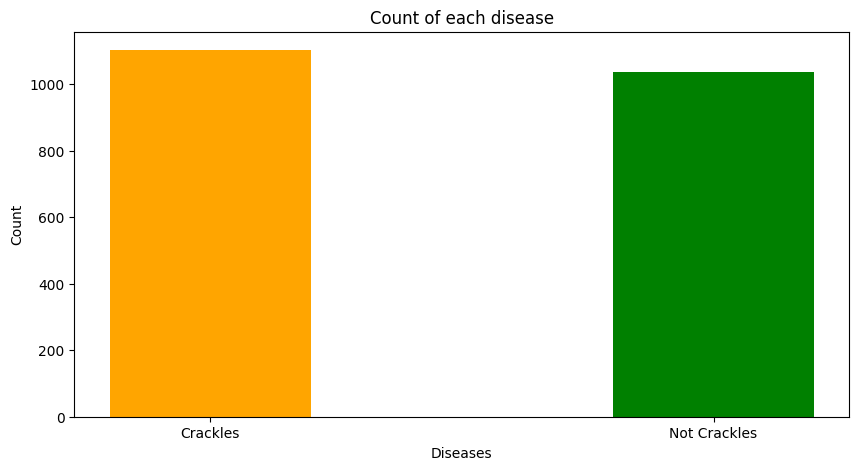

{'Crackles': 1102, 'Not Crackles': 1036}


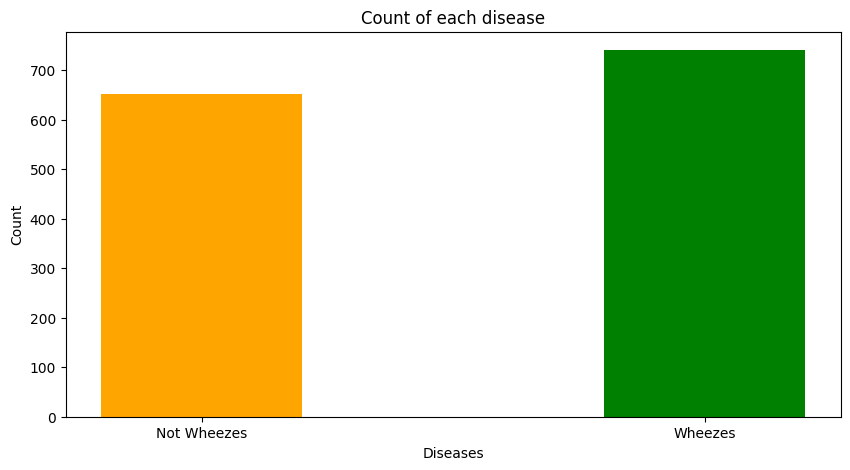

{'Not Wheezes': 653, 'Wheezes': 741}


In [ ]:
augmented_lables_count(crackles_lables)
augmented_lables_count(wheezes_lables)

In [ ]:
crackles_lables_encode = crackles_lables.reshape(crackles_lables.shape[0],1)
crackles_lables_encode = np.where(crackles_lables_encode == 'Crackles',np.array([1,0]).reshape(1,2) , crackles_lables_encode)
crackles_lables_encode = np.where(crackles_lables_encode == 'Not Crackles',np.array([0,1]).reshape(1,2) , crackles_lables_encode)


wheezes_lables_encode = wheezes_lables.reshape(wheezes_lables.shape[0],1)
wheezes_lables_encode = np.where(wheezes_lables_encode == 'Wheezes',np.array([1,0]).reshape(1,2) , wheezes_lables_encode)
wheezes_lables_encode = np.where(wheezes_lables_encode == 'Not Wheezes',np.array([0,1]).reshape(1,2) , wheezes_lables_encode)

crackles_lables = crackles_lables_encode.astype('float64')
wheezes_lables = wheezes_lables_encode.astype('float64')

In [ ]:
x_crackles = np.array(crackles_features)
y_crackles = np.array(crackles_lables)

x_wheezes = np.array(wheezes_features)
y_wheezes = np.array(wheezes_lables)

print (x_crackles.shape , y_crackles.shape)
print (x_wheezes.shape , y_wheezes.shape)

(2138, 52) (2138, 2)
(1394, 52) (1394, 2)


## Data Split

In [ ]:
c_x_train, c_x_val, c_y_train, c_y_val  = train_test_split(x_crackles,y_crackles, test_size=0.175, random_state=10)
c_x_train, c_x_test, c_y_train, c_y_test = train_test_split(c_x_train, c_y_train, test_size=0.075, random_state=10)

w_x_train, w_x_val, w_y_train, w_y_val  = train_test_split(x_wheezes, y_wheezes, test_size=0.175, random_state=10)
w_x_train, w_x_test, w_y_train, w_y_test = train_test_split(w_x_train, w_y_train, test_size=0.075, random_state=10)

print (c_x_train.shape, c_x_val.shape, c_x_test.shape)
print (c_y_train.shape, c_y_val.shape, c_y_test.shape)

print (w_x_train.shape, w_x_val.shape, w_x_test.shape)
print (w_y_train.shape, w_y_val.shape, w_y_test.shape)

(1630, 52) (375, 52) (133, 52)
(1630, 2) (375, 2) (133, 2)
(1063, 52) (244, 52) (87, 52)
(1063, 2) (244, 2) (87, 2)


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-6e9rmed2
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-6e9rmed2
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


# ENSEMBLE  Model

## Build Model

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dense, Dropout, Input, GlobalMaxPooling1D, MultiHeadAttention, Bidirectional, GRU, Average
from tensorflow.keras.models import Model

# Define the CNN model
def create_cnn_model(input_shape):
    input_layer = Input(shape=input_shape)
    conv1 = Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu')(input_layer)
    conv1 = MaxPooling1D(pool_size=2, strides=2, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv2 = Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu')(conv1)
    conv2 = MaxPooling1D(pool_size=2, strides=2, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv3 = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(conv2)
    conv3 = MaxPooling1D(pool_size=2, strides=2, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    global_max_pooling = GlobalMaxPooling1D()(conv3)
    dense1 = Dense(128, activation='relu')(global_max_pooling)
    dense1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dense1)
    dense2 = Dropout(0.5)(dense2)
    return Model(inputs=input_layer, outputs=dense2)

# Define the GRU model
def create_gru_model(input_shape):
    input_layer = Input(shape=input_shape)
    gru1 = Bidirectional(GRU(256, return_sequences=True))(input_layer)
    gru2 = Bidirectional(GRU(128))(gru1)
    dense1 = Dense(128, activation='relu')(gru2)
    dense1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dense1)
    dense2 = Dropout(0.5)(dense2)
    return Model(inputs=input_layer, outputs=dense2)

# Define the Transformer model
def create_transformer_model(input_shape):
    input_layer = Input(shape=input_shape)
    conv1 = Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu')(input_layer)
    conv1 = MaxPooling1D(pool_size=2, strides=2, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv2 = Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu')(conv1)
    conv2 = MaxPooling1D(pool_size=2, strides=2, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv3 = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(conv2)
    conv3 = MaxPooling1D(pool_size=2, strides=2, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    transformer_output = MultiHeadAttention(num_heads=8, key_dim=512)(conv3, conv3, conv3)
    global_max_pooling = GlobalMaxPooling1D()(transformer_output)
    dense1 = Dense(128, activation='relu')(global_max_pooling)
    dense1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dense1)
    dense2 = Dropout(0.5)(dense2)
    return Model(inputs=input_layer, outputs=dense2)

# Input layer
input_layer = Input(shape=(52, 1))

# Create CNN, GRU, and Transformer models
cnn_model = create_cnn_model((52, 1))
gru_model = create_gru_model((52, 1))
transformer_model = create_transformer_model((52, 1))

# Combine the outputs of the models
combined_output = Average()([cnn_model(input_layer), gru_model(input_layer), transformer_model(input_layer)])

# Additional Dense layers
dense_combined = Dense(128, activation='relu')(combined_output)
dense_combined = Dropout(0.5)(dense_combined)
dense_combined = Dense(64, activation='relu')(dense_combined)
dense_combined = Dropout(0.5)(dense_combined)

# Output layer
output_layer = Dense(2, activation='softmax')(dense_combined)

# Create the ensemble model
ensemble_model = Model(inputs=input_layer, outputs=output_layer)
ensemble_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 52, 1)]              0         []                            
                                                                                                  
 model_9 (Functional)        (None, 64)                   1320928   ['input_11[0][0]']            
                                                          0                                       
                                                                                                  
 model_10 (Functional)       (None, 64)                   932032    ['input_11[0][0]']            
                                                                                                  
 model_11 (Functional)       (None, 64)                   2161068   ['input_11[0][0]']     

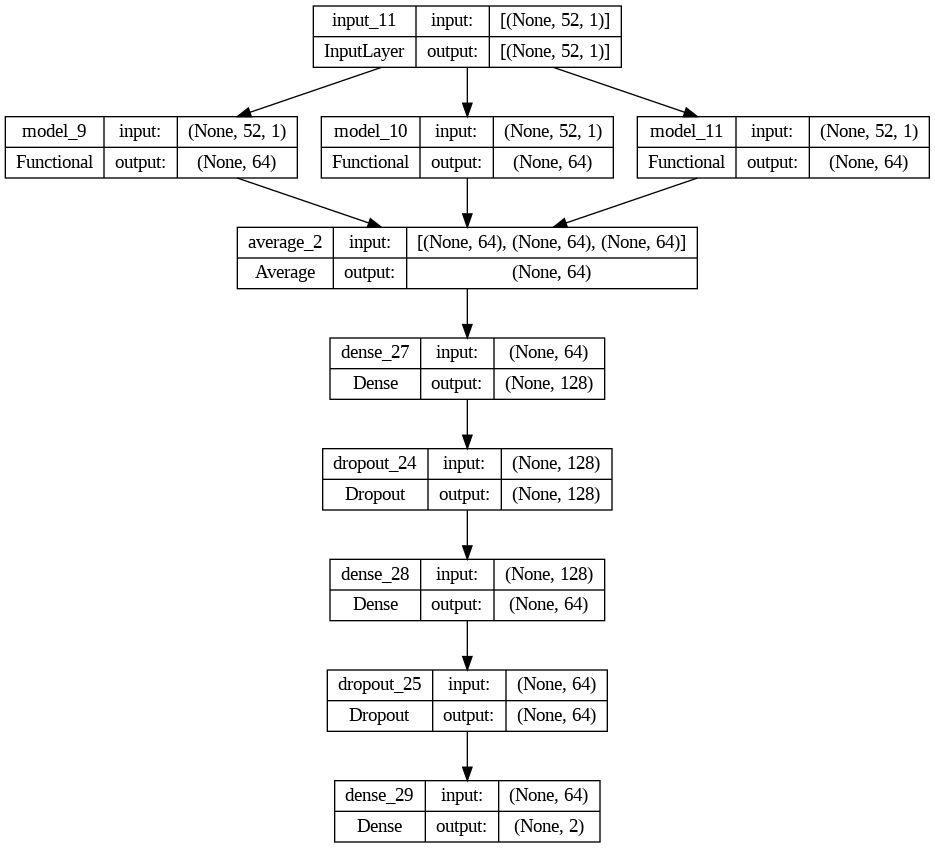

In [ ]:
tf.keras.utils.plot_model(ensemble_model, "Ensemble_Model.png", show_shapes=True)

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Crackles

In [ ]:
c_x_train_ensemble = np.expand_dims(c_x_train, axis=2)
c_x_val_ensemble = np.expand_dims(c_x_val, axis=2)
c_x_test_ensemble = np.expand_dims(c_x_test, axis=2)

## Train Model

In [ ]:
cb = [EarlyStopping(patience=20,monitor='val_accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("/content/C_ENSEMBLE_CNN_1.h5",save_best_only=True)]

In [ ]:
c_history = model.fit(c_x_train_ensemble, c_y_train, batch_size=16, epochs=150, validation_data=(c_x_val_ensemble, c_y_val), callbacks=cb)

Epoch 1/250
102/102 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.6528

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


102/102 [==============================] - 29s 57ms/step - loss: 0.6388 - accuracy: 0.6528 - val_loss: 1.3176 - val_accuracy: 0.5040
Epoch 2/250
102/102 [==============================] - 4s 42ms/step - loss: 0.6172 - accuracy: 0.6761 - val_loss: 1.1576 - val_accuracy: 0.5040
Epoch 3/250
102/102 [==============================] - 4s 36ms/step - loss: 0.6130 - accuracy: 0.6761 - val_loss: 0.7677 - val_accuracy: 0.5360
Epoch 4/250
102/102 [==============================] - 4s 35ms/step - loss: 0.6001 - accuracy: 0.6890 - val_loss: 0.6758 - val_accuracy: 0.5920
Epoch 5/250
102/102 [==============================] - 3s 29ms/step - loss: 0.5567 - accuracy: 0.7227 - val_loss: 0.8342 - val_accuracy: 0.5893
Epoch 6/250
102/102 [==============================] - 3s 31ms/step - loss: 0.5575 - accuracy: 0.7147 - val_loss: 2.1499 - val_accuracy: 0.4960
Epoch 7/250
102/102 [==============================] - 4s 38ms/step - loss: 0.5237 - accuracy: 0.7356 - val_loss: 0.5452 - val_accuracy: 0.7280
Epo

## Evaluate Model

In [ ]:
model.evaluate(c_x_val_ensemble, c_y_val)

12/12 [==============================] - 1s 22ms/step - loss: 0.1694 - accuracy: 0.9573


[0.16938334703445435, 0.9573333263397217]

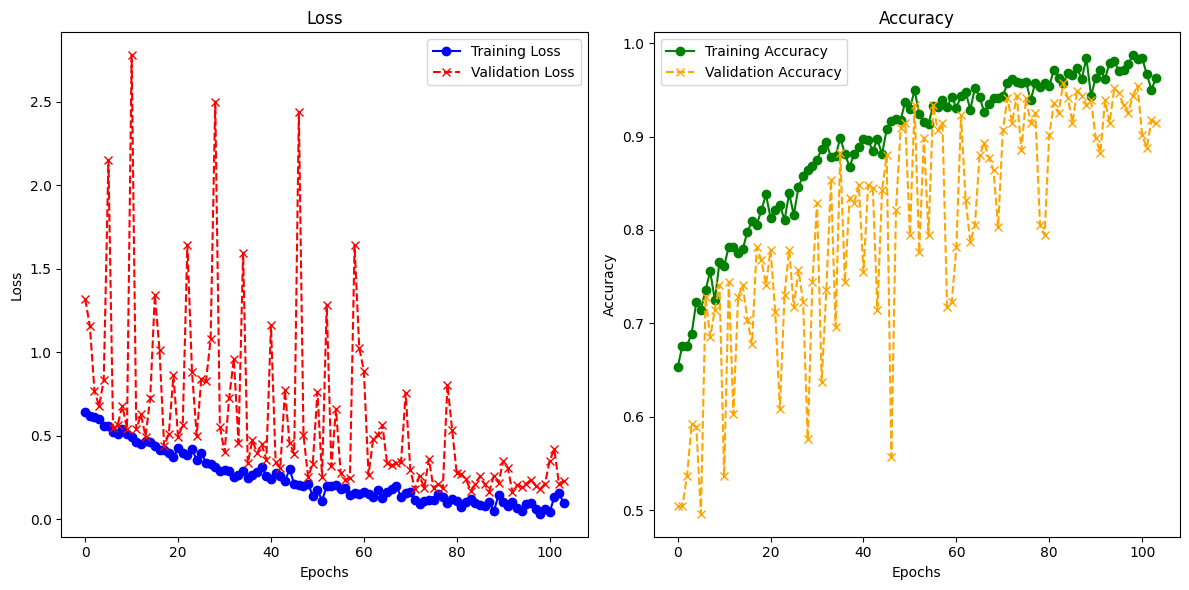

In [ ]:
def plot_loss_curves(history):
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', marker='x')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', marker='x')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with  training history
plot_loss_curves(c_history)

## Results

5/5 [==============================] - 0s 16ms/step


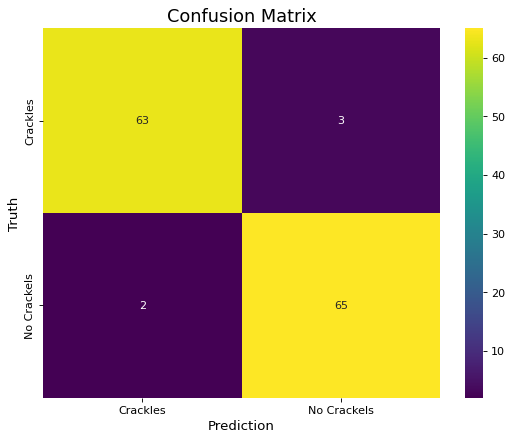

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming classes defined as ["Crackles", "No Crackels"]
classes = ["Crackles", "No Crackels"]

# Assuming preds and y_testclass are defined
preds = model.predict(c_x_test_ensemble)
classpreds = [np.argmax(t) for t in preds]
y_testclass = [np.argmax(t) for t in c_y_test]

# Creating the confusion matrix
cm = confusion_matrix(y_testclass, classpreds)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
cmap = sns.color_palette("viridis", as_cmap=True)
ax = sns.heatmap(cm, cmap=cmap, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

# Adding labels and title
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Truth', fontsize=12)

# Displaying the plot
plt.show(ax)

In [ ]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

    Crackles       0.97      0.95      0.96        66
 No Crackels       0.96      0.97      0.96        67

    accuracy                           0.96       133
   macro avg       0.96      0.96      0.96       133
weighted avg       0.96      0.96      0.96       133



# Wheezes

In [ ]:
w_x_train_ensemble = np.expand_dims(w_x_train, axis=2)
w_x_val_ensemble = np.expand_dims(w_x_val, axis=2)
w_x_test_ensemble = np.expand_dims(w_x_test, axis=2)

## Train Model

In [ ]:
w_model = model
w_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 52, 1)]              0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 52, 2048)             12288     ['input_2[0][0]']             
                                                                                                  
 max_pooling1d_3 (MaxPoolin  (None, 26, 2048)             0         ['conv1d_3[0][0]']            
 g1D)                                                                                             
                                                                                                  
 batch_normalization_3 (Bat  (None, 26, 2048)             8192      ['max_pooling1d_3[0][0]'] 

In [ ]:
cb = [EarlyStopping(patience=20, monitor='val_accuracy', mode='max', restore_best_weights=True),
      ModelCheckpoint("/content/W_ENSEMBLE_MODEL.h5", save_best_only=True)]

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
w_model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
w_history = w_model.fit(w_x_train_ensemble, w_y_train, batch_size=16, epochs=250, validation_data=(w_x_val_ensemble, w_y_val), callbacks=cb)

Epoch 1/250
67/67 [==============================] - ETA: 0s - loss: 1.6620 - accuracy: 0.4581

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 10s 51ms/step - loss: 1.6620 - accuracy: 0.4581 - val_loss: 0.7230 - val_accuracy: 0.5492
Epoch 2/250
67/67 [==============================] - 4s 58ms/step - loss: 0.6631 - accuracy: 0.5447 - val_loss: 0.6758 - val_accuracy: 0.5615
Epoch 3/250
67/67 [==============================] - 3s 41ms/step - loss: 0.6534 - accuracy: 0.5682 - val_loss: 0.6565 - val_accuracy: 0.5984
Epoch 4/250
67/67 [==============================] - 3s 45ms/step - loss: 0.6560 - accuracy: 0.5484 - val_loss: 0.6385 - val_accuracy: 0.6148
Epoch 5/250
67/67 [==============================] - 5s 74ms/step - loss: 0.6324 - accuracy: 0.5776 - val_loss: 0.6342 - val_accuracy: 0.5902
Epoch 6/250
67/67 [==============================] - 2s 32ms/step - loss: 0.6452 - accuracy: 0.5842 - val_loss: 0.6513 - val_accuracy: 0.6434
Epoch 7/250
67/67 [==============================] - 3s 42ms/step - loss: 0.6356 - accuracy: 0.5889 - val_loss: 0.6252 - val_accuracy: 0.6311
Epoch 8/250
67/67

## Evaluate Model

8/8 [==============================] - 0s 40ms/step - loss: 0.1117 - accuracy: 0.9877


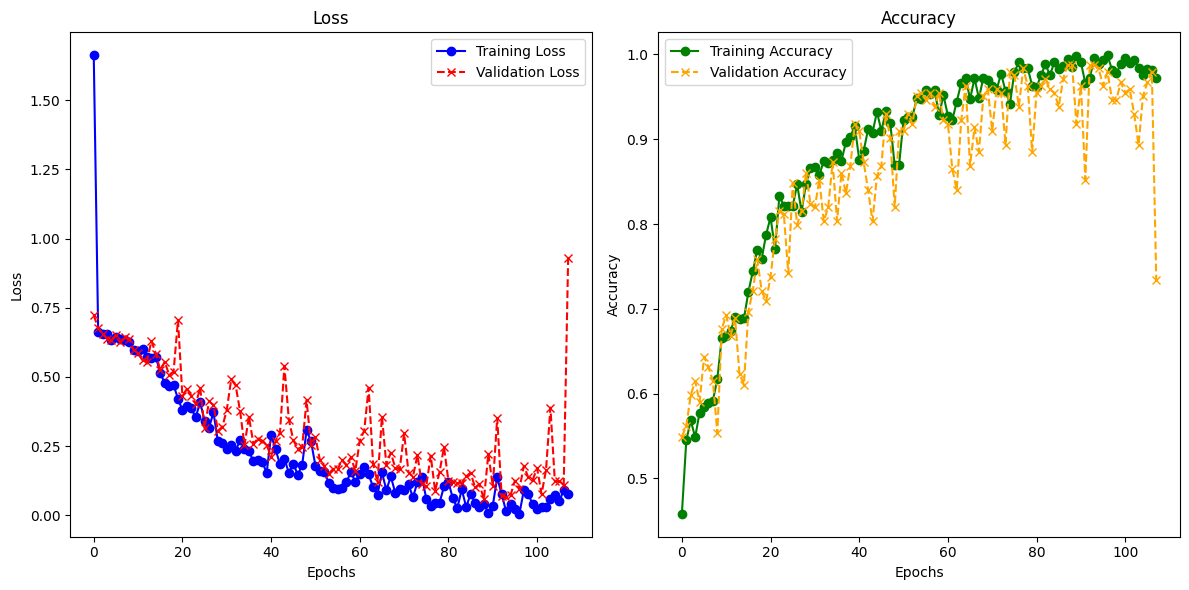

In [ ]:
w_model.evaluate(w_x_val_ensemble, w_y_val)
plot_loss_curves(w_history)

## Results

3/3 [==============================] - 0s 10ms/step


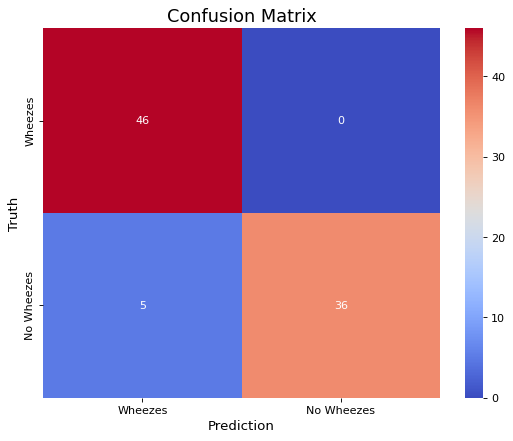

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming  classes defined as ["Wheezes", "No Wheezes"]
classes = ["Wheezes", "No Wheezes"]

# Assuming preds and y_testclass are defined
preds = w_model.predict(w_x_test_ensemble)
classpreds = [np.argmax(t) for t in preds]
y_testclass = [np.argmax(t) for t in w_y_test]

# Creating the confusion matrix
cm = confusion_matrix(y_testclass, classpreds)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
cmap = sns.color_palette("coolwarm", as_cmap=True)
ax = sns.heatmap(cm, cmap=cmap, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

# Adding labels and title
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Truth', fontsize=12)

# Displaying the plot
plt.show(ax)

In [ ]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

     Wheezes       0.90      1.00      0.95        46
  No Wheezes       1.00      0.88      0.94        41

    accuracy                           0.94        87
   macro avg       0.95      0.94      0.94        87
weighted avg       0.95      0.94      0.94        87



In [ ]:
w_model.save('/content/Ensemble_Model_97.78.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Prediction

In [ ]:
def wheezes_crackles_detection(audio_path):
    w_classes = ["Wheezes", "No Wheezes"]
    c_classes = ["Crackles", "No Crackles"]

    data_x, sampling_rate = librosa.load(audio_path)

    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=52).T, axis=0)

    features = features.reshape(1, 52)

    w_pred = w_model.predict(np.expand_dims(features, axis=2))
    w_classpreds = w_classes[np.argmax(w_pred, axis=1)[0]]
    w_confidence = w_pred.T[w_pred.mean(axis=0).argmax()].mean()

    c_pred = model.predict(np.expand_dims(features, axis=2))
    c_classpreds = c_classes[np.argmax(c_pred, axis=1)[0]]
    c_confidence = c_pred.T[c_pred.mean(axis=0).argmax()].mean()

    if "No" in w_classpreds and "No" in c_classpreds:
        print("Healthy")
    elif "No" in w_classpreds:
        print("Crackles")
    elif "No" in c_classpreds:
        print("Wheezes")
    else:
        print("Both Crackles and Wheezes")

audio_path = '/content/data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav'
wheezes_crackles_detection(audio_path)

1/1 [==============================] - 0s 82ms/step
Healthy


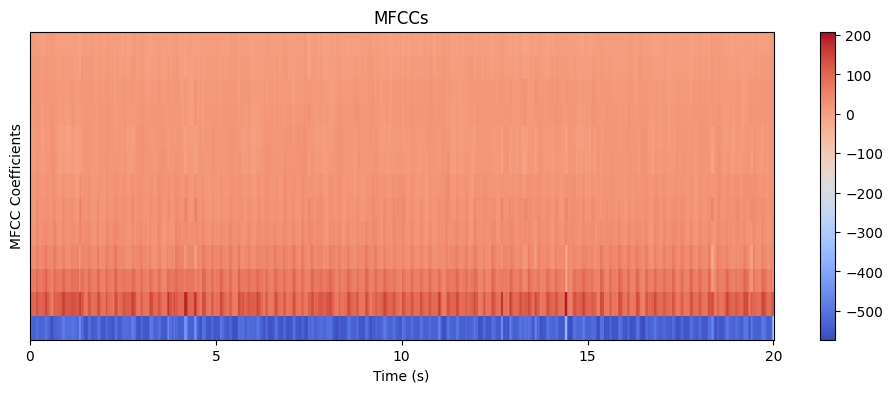

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
file_path = "/content/data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav"
y, sr = librosa.load(file_path)

# Compute MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plot the MFCCs
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.show()